## Training a Neural Network

We will be training a neural network using a modified version of the VAE network. By elmininating the KL divergence term on the loss function and setting epsilon equal to zero, we arrive at an autoencoder network that reconstructs hand-written digits. 

In [156]:
import pickle, gzip
import matplotlib.pyplot as plt 
#import auto_encoders
% matplotlib inline

In [157]:
with gzip.open('data\mnist.pkl.gz', 'rb') as f:
    train, test, val = pickle.load(f, encoding='latin1')
    mnist = train[0]

After we import the VAE class, we set up the parameters and intialize the weights. The loss function is the squared error and the activation function is the sigmoid. As part of backpropogation, we also need to pass in the derviative of the loss and activation. 

$$Loss(y, \hat{y}) = \sum (y - \hat{y})^2$$
$$\sigma(x) = \frac{1}{1 + exp(-x)}$$

In [158]:
import numpy as np

class VAE(object):

    def __init__(self, input_dim, output_dim, params):
        '''intializes weights matrix and parameters'''

        # initialize size of VAE 
        self.encoder_layer_sizes = input_dim + [2]
        self.decoder_layer_sizes = [2, 1] + output_dim[::-1] 
        self.total_layer_sizes   = input_dim + [2, 1] + output_dim[::-1]
       
        self.number_encoder_layers = len(self.encoder_layer_sizes) - 1
        self.number_decoder_layers = len(self.decoder_layer_sizes) - 1
        self.number_total_layers   = len(self.total_layer_sizes) - 1

        # intialize weights
        self.encoder_weights = {}
        for i in range(self.number_encoder_layers):
            self.encoder_weights[i] = np.random.uniform(-0.1, 0.1, 
                                                        (self.encoder_layer_sizes[i], 
                                                         self.encoder_layer_sizes[i+1])) 
        self.decoder_weights = {}
        for i in range(self.number_decoder_layers):
            self.decoder_weights[i] = np.random.uniform(-0.1, 0.1, 
                                                        (self.decoder_layer_sizes[i],
                                                         self.decoder_layer_sizes[i+1]))
        # set params
        self.alpha = params['alpha']
        self.max_iter = params['max_iter']
        self.activation = params['activation']
        self.grad_activation = params['grad_act']
        self.loss = params['loss']
        self.grad_loss = params['grad_loss']

    def train(self, train_data):
        '''trains the VAE model'''
        count = 0
        while count < self.max_iter:   
            
            # feed forward network
            yhat = self.feedforward(train_data)
            
            # backpropogate errors
            grad_encoder, grad_decoder = self.backprop(train_data, yhat)
        
            # update weights with gradient descent
            for i in range(self.number_decoder_layers):
                self.decoder_weights[i] -= self.alpha * grad_decoder[i]
                
            for i in range(self.number_encoder_layers):
                self.encoder_weights[i] -= self.alpha * grad_encoder[i]
                
            count += 1
        return None

    def predict(self, train_data):
        '''predicts on a trained VAE model'''        
        yhat = self.feedforward(train_data)
        return yhat
    
    def generate(self):
        '''generates new images from a trained VAE model'''        
        
        # sample from latent variable space
        self.z = self.z
        
        # feedforward on decoder
        self.gen_input = {}
        self.gen_activation = {}
        self.gen_input[0]     = self.z.T @ self.decoder_weights[0]
        self.gen_activation[0] = self.activation(self.gen_input[0])
        
        for i in range(1, self.number_decoder_layers):
            self.gen_input[i] = self.gen_input[i-1] @ self.decoder_weights[i]
            self.gen_activation[i] = self.activation(self.gen_input[i])

        return self.gen_activation[i]
    
    def KLD(self):
        '''Kullback–Leibler divergence loss'''
        pass

    def backprop(self, y, yhat):
        '''back-propagation algorithm'''
        # initialize 
        grad_decoder = {}
        grad_encoder = {}
    
        # backpropogate error through decoder layers
        rev_range = np.arange(self.number_decoder_layers)[::-1]
        n = rev_range[0]
        
        delta = - self.grad_loss(y, yhat) * self.grad_activation(self.decoder_input[n])
        grad_decoder[n] = self.decoder_activation[n-1].T @ delta
        
        for i in rev_range[1:-1]:
            delta = delta @ self.decoder_weights[i+1].T * self.grad_activation(self.decoder_input[i])
            grad_decoder[i] = self.decoder_activation[i-1].T @ delta 
            
        # backpropogate errors through encoder layers
        rev_range = np.arange(self.number_encoder_layers)[::-1]
        n = rev_range[0]
        
        delta = delta @ self.decoder_weights[1].T * self.grad_activation(self.decoder_input[0])
        grad_decoder[0] = self.encoder_activation[1].T @ delta
        
        delta = delta @ self.decoder_weights[0].T * self.grad_activation(self.encoder_input[n])
        grad_encoder[n] = self.encoder_activation[0].T @ delta
        
        for i in rev_range[1:-1]:
            delta = delta @ self.encoder_weights[i+1].T * self.grad_activation(self.encoder_input[i])
            grad_encoder[i] = self.encoder_activation[i-1].T @ delta
        
        delta = delta @ self.encoder_weights[1].T * self.grad_activation(self.encoder_input[0])
        grad_encoder[0] = y.T @ delta
    
        return grad_encoder, grad_decoder 
            
    def feedforward(self, train_data):
        '''feedforward update step'''
        
        # initialize storage for activations
        self.encoder_input = {}
        self.encoder_activation = {}
        self.decoder_input = {}
        self.decoder_activation = {}
        
        self.encoder_input[0]      = train_data @ self.encoder_weights[0]
        self.encoder_activation[0] = self.activation(self.encoder_input[0])
            
        # feedforward update on encoder network
        for i in range(1, self.number_encoder_layers):
            self.encoder_input[i] = self.encoder_input[i-1] @ self.encoder_weights[i]
            self.encoder_activation[i] = self.activation(self.encoder_input[i])
        
        # store output as encoded latent variable parameters
        
        self.mu = self.encoder_activation[i][:,1]
        self.sigma = self.encoder_activation[i][:,0]
        
        # sample latent variable using reparameterization trick
        self.z = np.array((self.mu.T, self.sigma.T)) 
        
        # feedforward update on the decoder network
        self.decoder_input[0]      = self.z.T @ self.decoder_weights[0]
        self.decoder_activation[0] = self.activation(self.decoder_input[0])
        
        for i in range(1, self.number_decoder_layers):
            self.decoder_input[i] = self.decoder_input[i-1] @ self.decoder_weights[i]
            self.decoder_activation[i] = self.activation(self.decoder_input[i])

        return self.decoder_activation[i]

In [159]:
params = {
    'alpha' : 0.1,
    'max_iter' : 2,
    'activation' : (lambda x: 1 / (1 + np.exp(-x))),
    'grad_act' : (lambda x: np.exp(-x) / (1 + np.exp(-x))**2),
    'loss' : (lambda y, yhat: 0.5 * np.sum((y - yhat)**2)),
    'grad_loss' : (lambda y, yhat: y - yhat)
}

example = vae([784, 200], [784, 200], params)

### Training on Digits

Here we pass a training digit, a zero, of size 28 by 28 pixels.

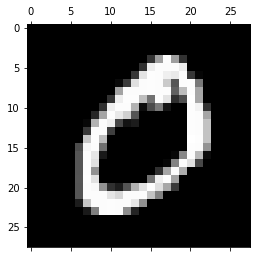

In [160]:
in_digit = np.array((mnist[1][None,:]))
plt.matshow(in_digit.reshape((28,28)), cmap='gray')
pass

We intialize the weights to be random, so the first pass looks jumbled.

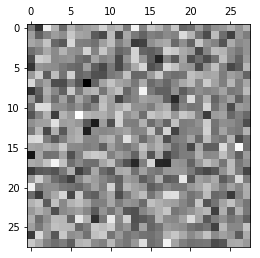

In [161]:
out_digit = example.feedforward(in_digit)
plt.matshow(out_digit.reshape((28,28)), cmap = 'gray')
pass

We then train the network to reduce the loss function and reproduce the training image. Here are the reconstructed images after just the first 10 training interations. It very rapidly reassembles the digit without error.

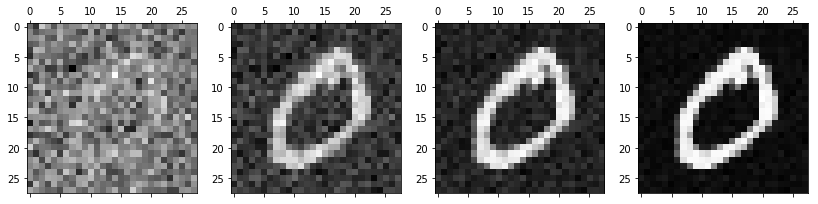

In [162]:
fig, ax = plt.subplots(1,4, figsize = (14, 10))

example.train(in_digit)
pred1 = example.predict(in_digit)
ax[0].matshow(pred1.reshape((28,28)), cmap='gray')

example.train(in_digit)
pred2 = example.predict(in_digit)
ax[1].matshow(pred2.reshape((28,28)), cmap='gray')

example.train(in_digit)
pred3 = example.predict(in_digit)
ax[2].matshow(pred3.reshape((28,28)), cmap='gray')

example.train(in_digit)
pred4 = example.predict(in_digit)
ax[3].matshow(pred4.reshape((28,28)), cmap='gray')
pass

### References

1. [MNIST data](http://deeplearning.net/tutorial/gettingstarted.html)